# Training a Machine Learning Classifier for HP-PPI Prediction Task

Classifier: XGBoost
- performs well with sparse variables
- needs no preprocessing

In [4]:
import os
import joblib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import sparse

from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report
from scikitplot.metrics import plot_confusion_matrix, plot_roc
from hyperopt import hp, tpe, STATUS_OK, Trials, space_eval
from hyperopt.fmin import fmin

from IPython.display import display, Markdown

# Suppress warnings
import warnings
from sklearn.exceptions import UndefinedMetricWarning

warnings.simplefilter('ignore', category=(UndefinedMetricWarning, RuntimeWarning))

In [2]:
# Set up directories
parent_dir = os.path.dirname(os.getcwd())

dir_in = os.path.join(parent_dir, 'data', 'features')
dir_out = os.path.join(parent_dir, 'data', 'results')

In [3]:
# Function for combining datasets
def get_dataset(pathogens):
    '''Combine features and labels of different pathogen datasets'''
    
    X = []
    y = []
    
    # Iterate through datasets
    for pathogen in pathogens:
        f_in = os.path.join(dir_in, '%s_features.pkl' % pathogen)
        X_, y_ = joblib.load(f_in)
        X.append(X_)
        y.append(y_)
    
    # Combine features (X) and labels (y)
    X = sparse.vstack(X)
    y = np.concatenate(y)
    
    return X, y

## Hyperparameter Tuning

Bayesian optimization with `hyperopt`

In [4]:
# Load all datasets
pathogens = ['Bacan', 'Yerpe', 'Fratu']
X, y = get_dataset(pathogens)

dtrain = xgb.DMatrix(X, label=y)

# Set up base classifier
clf = XGBClassifier(random_state=7)

In [5]:
# Define objective function
def get_score(params):
    _ = clf.set_params(**params)
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)
    score = cross_val_score(clf, X, y, cv=cv, scoring='f1', n_jobs=4).mean()
    
    return score

def f(params):
    score = get_score(params)
    return {'loss': -score, 'status': STATUS_OK}

In [6]:
# Define hyperparameter search space
param_space = {
    'max_depth': hp.choice('max_depth', range(1, 51)),
    'learning_rate': hp.uniform('learning_rate', 0.001, 1.0),
    'min_child_weight': hp.choice('min_child_weight', range(31)),
    'max_delta_step': hp.choice('max_delta_step', range(21)),
    'gamma': hp.loguniform('gamma', np.log(10)*-3, np.log(10)),
    
    'subsample': hp.uniform('subsample', 0.2, 1.),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.2, 1.),
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.2, 1.),
    
    'reg_alpha': hp.uniform('reg_alpha', 0., 1.),
    'reg_lambda': hp.uniform('reg_lambda', 0., 1.),
    'scale_pos_weight': hp.uniform('scale_pos_weight', 0.1, 20.)
}

# Begin optimization
trials = Trials()
best = fmin(objective, param_space, algo=tpe.suggest, max_evals=200, trials=trials)

# Obtain parameters of best model
best_params = space_eval(param_space, best)
best_params

 38%|███▊      | 77/200 [58:44<1:39:31, 48.55s/it, best loss: -0.9027289999999999]


KeyboardInterrupt: 

In [ ]:
# Set up classifier
clf.set_params(**best_par)
_ = clf.fit(X, y)

# Dump model as pickle
_ = joblib.dump(clf, 'best_model.pkl')

## Evaluate model on partitioned datasets

                               Test 1                                
                          Test Pathogen: Bacan
                          
              precision    recall  f1-score   support

           0     0.9032    0.8912    0.8972     10777
           1     0.5966    0.6277    0.6118      2764

    accuracy                         0.8374     13541
   macro avg     0.7499    0.7594    0.7545     13541
weighted avg     0.8406    0.8374    0.8389     13541



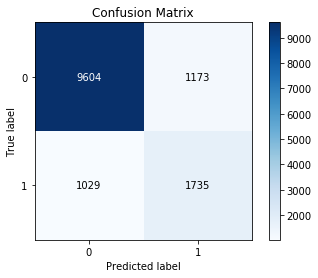

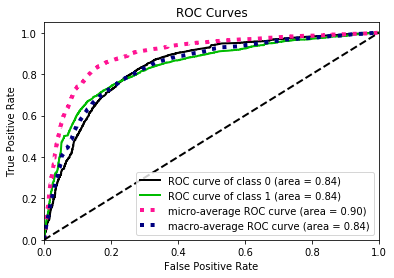

<hr></hr>

                               Test 2                                
                          Test Pathogen: Yerpe
                          
              precision    recall  f1-score   support

           0     0.8868    0.9344    0.9100     13137
           1     0.7012    0.5635    0.6249      3590

    accuracy                         0.8548     16727
   macro avg     0.7940    0.7489    0.7674     16727
weighted avg     0.8470    0.8548    0.8488     16727



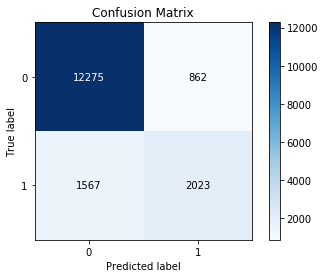

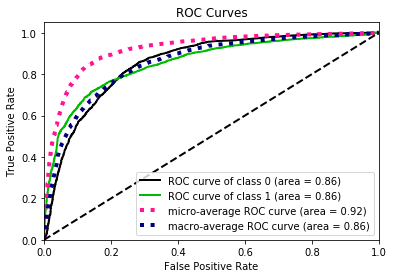

<hr></hr>

                               Test 3                                
                          Test Pathogen: Fratu
                          
              precision    recall  f1-score   support

           0     0.9128    0.9451    0.9287      3500
           1     0.8194    0.7338    0.7742      1187

    accuracy                         0.8916      4687
   macro avg     0.8661    0.8395    0.8515      4687
weighted avg     0.8891    0.8916    0.8896      4687



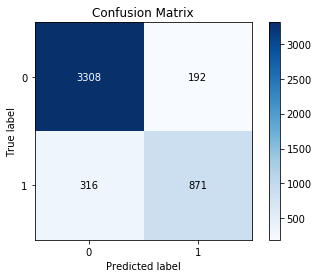

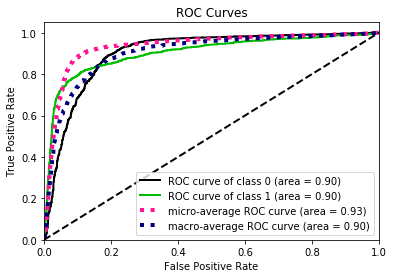

<hr></hr>

In [8]:
# Train and test classifier on different datasets
## Partition datasets by pathogen species
i = 0 # track number of tests

for p_test in pathogens:
    p_train = [p for p in pathogens if p != p_test]
    X_train, y_train = get_dataset(p_train)
    
    # Train classifier
    #_ = clf.fit(X_train, y_train)
    
    # Evaluate performance on test set
    X_test, y_test = get_dataset([p_test])
    y_pred = clf.predict(X_test)
    y_proba = clf.predict_proba(X_test)
    
    i += 1
    
    print('Test %i'.center(70) % i)
    print('Test Pathogen: %s\n'.center(70) % p_test)
    print(classification_report(y_test, y_pred, digits=4))
    
    # Plot metrics
    _ = plot_confusion_matrix(y_test, y_pred)
    _ = plot_roc(y_test, y_proba)
    _ = plt.show()
    
    display(Markdown('<hr></hr>'))